# Star Wars Retrieval-Augmented Generation (RAG) System

This Jupyter Notebook demonstrates a Retrieval-Augmented Generation (RAG) system designed to answer questions about the Star Wars universe. The system combines a retriever that fetches relevant documents from a knowledge base with a language model that generates answers based on these documents. The core components include embeddings for vector representations, a FAISS vector store for efficient retrieval, and a conversational retrieval chain.

### Contributions
This project has been developed as a class project for the course **Natural Language Processing**, taught by **Dr. Giorgio Satta**, at the University of Padua, in June 2024.
The contributors are **Shabnam Zareshahraki** and **Joseph Fiume**, with badge numbers 2091106 and 2043999, respectively.

## 0. Installation
Ensure you have the following libraries installed:


* `langchain`
* `faiss-gpu`
* `langchain_community`
* `accelerate`
* `transformers`

To install, run the cell below

In [28]:
!pip install -q transformers
!pip install -q "datasets<=2.18.0"
!pip install -q sentence-transformers
!pip install -q langchain
!pip install -q langchain_community
!pip install -q langchainhub
!pip install -q torch
!pip install -q faiss-gpu
!pip install -q "bitsandbytes<=0.40.2"
!pip install -q accelerate

## 1. Import Statements

This section imports the necessary libraries:

* `langchain_community.embeddings` and `langchain.embeddings`: For creating vector representations.
* `HuggingFacePipeline`: Interface for language model processing using HuggingFace.
* `RecursiveCharacterTextSplitter`: Splits text into smaller chunks for processing.
* `FAISS`: Library for efficient similarity search and clustering of dense vectors.
* `RetrievalQA` and `ConversationalRetrievalChain`: Combine LLM, retriever, and memory for conversational QA tasks.
* `PromptTemplate`: Structures prompts for language models.
* `LocalFileStore`: Handles local file storage.
* `StdOutCallbackHandler`: Manages callback handling.
* `matplotlib.pyplot`: For visualization.
* `ConversationBufferMemory`: Stores and manages conversation history.
* `concatenate_datasets`: Concatenates datasets for processing.
* Various `HuggingFace` transformers and utilities (`AutoTokenizer`, `AutoModelForSeq2SeqLM`, `pipeline`, `Text2TextGenerationPipeline`, `BitsAndBytesConfig`, `AutoConfig`, `AutoModelForCausalLM`): Handle model and pipeline tasks.
* `torch`: Deep learning library.
* `re`: For regular expression operations.
* `collections.Counter`: For counting hashable objects.
* `WordCloud`: Generates word clouds.
* `pandas`: For data manipulation and analysis.

















In [29]:
# Import necessary libraries for creating vector representations, language model processing, and visualization

# Import HuggingFace embeddings for creating vector representations
import langchain_community.embeddings
import langchain.embeddings

# Import HuggingFace pipeline for language model processing
from langchain_community.llms import HuggingFacePipeline

# Import text splitter to split text into smaller chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Import FAISS for efficient similarity search and clustering of dense vectors
from langchain_community.vectorstores import FAISS

# Import RetrievalQA and ConversationalRetrievalChain for combining LLM, retriever, and memory for QA tasks
from langchain.chains import RetrievalQA, ConversationalRetrievalChain

# Import PromptTemplate for structuring prompts
from langchain.prompts import PromptTemplate

# Import LocalFileStore for local storage
from langchain.storage import LocalFileStore

# Import StdOutCallbackHandler for callback handling
from langchain.callbacks import StdOutCallbackHandler

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Import ConversationBufferMemory for conversation memory handling
from langchain.memory import ConversationBufferMemory

# Import concatenate_datasets for dataset concatenation
from datasets import concatenate_datasets, load_dataset

# Import various HuggingFace transformers and utilities for model and pipeline handling
from transformers import (
    AutoTokenizer, AutoModelForSeq2SeqLM, pipeline,
    Text2TextGenerationPipeline, BitsAndBytesConfig,
    AutoConfig, AutoModelForCausalLM
)
import torch

# Import re for regular expressions
import re

# Import Counter from collections for counting hashable objects
from collections import Counter

# Import WordCloud for word cloud generation
from wordcloud import WordCloud

# Import pandas for data manipulation and analysis
import pandas as pd

## 2. Helpers

Below are some functions that have been define to enhance readability, reusability, and modularity of the system.

In [30]:
class Settings:
    topP = 50
    temperature = 0.7
    queries = [
        "How was Mark Hamill's performance?",
        "What are some themes in the movies?",
        "What are the criticisms of the sequels?",
        "How is the celebration scene with the Ewoks in Return of the Jedi perceived?",
        "What are the strengths and weaknesses of Return of the Jedi?",
        "How have special effects evolved from the original to the new movies?",
        "Do the viewers like the sequels as much as the originals?"
    ]

In [31]:
# Removes tags from the given strings

def remove_tags(text):
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

## 2. Load Data
We are going to use the imdb dataset provided by huggingface. The dataset is easy to use and to load.
The imdb datset comes with 3 seperate sets of data as can be seen above: train, test, and unsupervised. For our applicaiton we only want the text to give the LLM to train. It does not have to be labeled so we can treat the data as all unsupervised. We will combine all the data into a single dataset.

In [32]:
# Load the IMDB dataset from the HuggingFace datasets library
imdb_dataset = load_dataset("stanfordnlp/imdb")

# Print available splits to ensure the dataset is loaded correctly
print(imdb_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


In [33]:
# Combine the train, test, and unsupervised splits into a single dataset
combined_dataset = concatenate_datasets([imdb_dataset['train'], imdb_dataset['test'], imdb_dataset['unsupervised']])

# Print the combined dataset to ensure it has been merged correctly
print(combined_dataset)

# Print the first entry of the combined dataset as a sample
print(combined_dataset[2])

Dataset({
    features: ['text', 'label'],
    num_rows: 100000
})
{'text': "If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story.<br /><br />One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives (unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film).<br /><br />One might better spend one's time staring out a window at a tree growing.<br /><br />", 'label': 0}


We want to narrow down our dataset to just one topic. We decided for this project to make that topic Star Wars. There are in total 9 movies: 3 classic movies, 3 movies from the early 2000s and 3 recent movies.

In [34]:
# Define the movie you want to filter by
specific_movie = "Star Wars"

# Define a function to filter texts containing the specific word or phrase
def filter_texts(example):
    return bool(re.search(rf'\b{specific_movie}\b', example['text'], re.IGNORECASE))

# Apply the filter to the combined dataset
filtered_dataset = combined_dataset.filter(filter_texts)

# Verify the filtered dataset by printing it
print(filtered_dataset)

# Print the first entry of the filtered dataset as a sample
target_sample = filtered_dataset[15]["text"]
keyword_index = target_sample.lower().find(" star ")
search_offset = 30

target_sample[
    max(keyword_index - search_offset, 0):
    min(len(target_sample), keyword_index + search_offset)
]

Dataset({
    features: ['text', 'label'],
    num_rows: 618
})


"ctly like a tuskan raider from star wars. I'll call him Tusk"

As mentioned above the domain for our project is Star Wars. Star Wars is now a large universe with movies, television shows, theme park rides, books, comics, and toys. It was originally 3 movies that redefinded the genre of science fiction movies, and was the introduction of modern special effects.

The dataset we are using is the IMDB dataset provided by `HuggingFace`. Considering the dataset is limited to movie reviews, the rest of the Star Wars universe is excluded except for the 9 movies. The 9 movies vary in age. It is plausible that the older movies have more reviews and will provide better context for LLM.

Dataset profiling with a summary of through descriptive statistics can be found below:

The code above performs several profiling tasks on the filtered dataset:

1. Converts the dataset to a pandas DataFrame.
2. Displays the first few rows of the dataset.
3. Provides descriptive statistics for numerical columns.
4. Displays frequency counts for the 'label' column.
5. Checks for missing values.
6. Provides a summary of text lengths for the 'text' column.

In [35]:
# Convert the filtered dataset to a pandas DataFrame
df = pd.DataFrame(filtered_dataset)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(df.head())

# Basic Statistics for Numerical Columns
print("\nDescriptive Statistics for Numerical Columns:")
print(df.describe())

# Frequency Counts for Categorical Columns
print("\nFrequency Counts for 'label' Column:")
print(df['label'].value_counts())

# Check for Missing Values
print("\nMissing Values Summary:")
print(df.isnull().sum())

# Custom Function to Summarize Text Data Lengths
def text_length_summary(df, column):
    text_lengths = df[column].apply(len)
    print(f"\nText Length Summary for '{column}':")
    print(f"Count: {len(text_lengths)}")
    print(f"Mean: {text_lengths.mean()}")
    print(f"Median: {text_lengths.median()}")
    print(f"Min: {text_lengths.min()}")
    print(f"Max: {text_lengths.max()}")
    print(f"Standard Deviation: {text_lengths.std()}")
    print(f"Quantiles: {text_lengths.quantile([0.25, 0.5, 0.75])}")
    print(f"Variance: {text_lengths.var()}")
    print(f"Skewness: {text_lengths.skew()}")
    print(f"Kurtosis: {text_lengths.kurt()}")

# Apply the Text Length Summary Function
text_length_summary(df, 'text')

Dataset Preview:
                                                text  label
0  As a kid I did think the weapon the murderer w...      0
1  I have just lost three hours of my life to thi...      0
2  Well, on it's credit side (if it can be said t...      0
3  Anyone who has a remote interest in science fi...      0
4  I can't believe this movie managed to get such...      0

Descriptive Statistics for Numerical Columns:
            label
count  618.000000
mean    -0.237864
std      0.834851
min     -1.000000
25%     -1.000000
50%      0.000000
75%      1.000000
max      1.000000

Frequency Counts for 'label' Column:
label
-1    306
 1    159
 0    153
Name: count, dtype: int64

Missing Values Summary:
text     0
label    0
dtype: int64

Text Length Summary for 'text':
Count: 618
Mean: 1934.7459546925566
Median: 1461.5
Min: 246
Max: 9420
Standard Deviation: 1382.7775369001813
Quantiles: 0.25     926.25
0.50    1461.50
0.75    2447.50
Name: text, dtype: float64
Variance: 1912073.71655573

The following cell performs the following tasks:

1. Combines all text data into a single string.
2. Performs a word count analysis using the `Counter` from the collections module.
3. Generates and displays a word cloud using the `WordCloud` class from the wordcloud module.

Counter({'the': 10958, 'of': 5415, 'a': 5218, 'and': 5088, 'to': 4465, 'is': 3252, 'in': 2972, 'that': 2368, 'I': 2146, 'it': 1817, 'this': 1781, 'was': 1579, 'as': 1530, 'with': 1405, 'for': 1388, 'The': 1364, 'but': 1121, 'are': 1096, 'on': 1027, 'movie': 958, 'have': 950, 'be': 926, 'not': 868, 'you': 860, 'film': 837, 'like': 805, 'from': 791, 'one': 755, 'they': 749, 'his': 725, 'at': 724, 'all': 717, 'by': 704, 'Star': 681, 'or': 637, 'an': 626, 'he': 606, 'has': 561, 'so': 557, 'who': 550, 'just': 548, 'about': 522, 'more': 495, 'out': 494, 'some': 491, 'can': 461, 'Wars': 448, 'even': 433, 'if': 421, "it's": 420, 'were': 419, 'good': 414, 'what': 405, 'than': 401, 'when': 400, 'very': 390, 'This': 380, 'would': 377, 'up': 375, 'only': 374, 'It': 370, 'which': 366, 'no': 363, 'my': 358, 'their': 358, 'had': 348, 'really': 343, 'into': 339, 'there': 335, 'most': 333, 'its': 328, 'will': 323, '-': 322, 'other': 312, 'see': 310, 'first': 307, 'get': 297, 'been': 293, 'much': 291, '

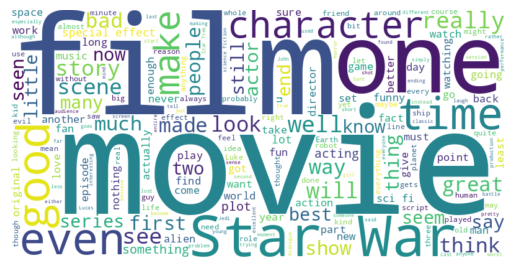

In [36]:
# Combine all text data into a single string
all_text = " ".join(df['text'])
all_text = remove_tags(all_text)

# Perform word count analysis
word_counts = Counter(all_text.split())
print(word_counts)

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 3. Embeddings
We utilize `LangChain` to use with our sentence embeddings. Sentence embeddings are fixed-size vector representations of sentences. These vectors capture the semantic meaning of sentences. LangChain simplifies the process of generating and utilizing sentence embeddings by providing seamless integration with pre-trained language models and embedding models. We chose LangChain for its flexabilty working with different LLMs and different vector stores.

This code performs the following tasks:

1. Initializes the `RecursiveCharacterTextSplitter` with specified parameters.
2. Extracts texts from the filtered dataset.
3. Concatenates all texts into a single string.
4. Splits the concatenated text into smaller chunks.
5. Prints the first two text chunks as a sample.

In [37]:
# Initialize the text splitter with specific chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
    # separators=[
    #     "\n\n",
    #     ".",
    #     "\n",
    #     " ",
    #     "",
    # ]
)

# Extract texts from the dataset
text = filtered_dataset["text"]

# Concatenate all texts into a single string
concatenated_text = " ".join(text)

# Split the concatenated text into smaller chunks
texts = text_splitter.create_documents([concatenated_text])

# Print the first two text chunks as a sample
print(texts[:2])

[Document(page_content='As a kid I did think the weapon the murderer wielded was cool, however I was a kid and so I was a bit dumb. Even as a dumb kid though the movies plot was stupid and a bit boring when the killer was not using his light knife to kill people. What amazes me is that the movie has a really solid cast in it. What script did they read when agreeing to be in this movie as it is most assuredly boring and only a means to show off a light saber on a very small scale. The plot at times is incomprehensible and the end is totally chaotic. The whole film seems to rotate around aliens and the one weapon. The plot has two kids and some dude having an alien encounter, flash years later and there seems to be a return as it were in the mix. Dead animals and such to be explored and for some reason the one dude gets the weapon of the aliens and proceeds to use it to go on a very light killing spree. Seriously, you just have to wonder why this movie was made, if you are going to have 

## 4. Vector Store

We are using `FAISS` (Facebook AI Similarity Search) for efficient similarity search and clustering of dense vectors. FAISS serves as a vector store for managing and querying the high-dimensional embeddings of our textual data. We chose FAISS for its speed, flexibility and high performance.


The cell below performs the following tasks:

1. Initializes a local file store for caching embeddings.
2. Defines the embedding model ID.
3. Initializes the core embeddings model using `HuggingFace`.
4. Initializes cache-backed embeddings using the core embeddings model and local file store.
5. Creates a FAISS vector store from the text chunks and the embedder.

In [38]:
# Initialize a local file store for caching embeddings
store = LocalFileStore("./cache/")

# Define the embedding model ID
embed_model_id = 'sentence-transformers/all-MiniLM-L6-v2'

# Initialize the core embeddings model using HuggingFace
core_embeddings_model = langchain_community.embeddings.HuggingFaceBgeEmbeddings(
    model_name=embed_model_id
)

# Initialize cache-backed embeddings using the core embeddings model and local file store
embedder = langchain.embeddings.cache.CacheBackedEmbeddings.from_bytes_store(
    core_embeddings_model, store, namespace=embed_model_id
)

# Create a FAISS vector store from the text chunks and the embedder
vector_store = FAISS.from_documents(texts, embedder)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## 5. Prompt Engineering



This code provided in the cell below performs the following tasks:

1. Defines a query.
2. Generates the embedding vector for the query.
3. Performs a similarity search using the embedding vector, retrieving the top k(=4) similar documents.
4. Prints the content of the retrieved documents.


In [39]:
# Loads context related to a given query by performing a similarity search using embedding vectors.
def load_context(query, k=4):
  context = ""

  # Generate the embedding vector for the query
  embedding_vector = core_embeddings_model.embed_query(query)

  # Retrieve top k(=4) similar documents based on the embedding vector
  docs = vector_store.similarity_search_by_vector(embedding_vector, k=4)
  for doc in docs:
    context += doc.page_content
  return context

# Example usage of load_context function
load_context("star wars")

'the movie such as "This movie stinks because Luke is not in it!" then this meritorious film will become another spectacular movie that will be the subject of derision like ROTJ suffered unfortunately.<br /><br /> first, i\'d like to say that, while i know my share about star wars, i am not a fanatic. i do not know how many chromosomes a Wamp Rat has or the extended family of TK427. what i know is this: Star wars, all the movies(less so with episode 2 though), captured something magical. it\'s hard to say what, what button Lucas has found and boldly pressed, but it works. Star Wars is more than a movie. it\'s an idea.<br /><br />How, may you ask? i shall explain. star wars touches on the most universal of stereotypes, good vs evil. it does this so obviously, so profoundly, that literally any person from any environment can understand. Episode VI does the very well, concluding the epic struggle between a son and his used and manipulated father, yet also, with the addition of the prequel

In [40]:
# Retrieves the top k(=4) similar documents for a given query using embedding vectors.
def retrieve_similar_docs(query, k=4):
    # Define the query
    query = Settings.queries[0]

    # Generate the embedding vector for the query
    embedding_vector = core_embeddings_model.embed_query(query)

    # Perform a similarity search using the embedding vector, retrieving the top k similar documents (k=4, by default)
    docs = vector_store.similarity_search_by_vector(embedding_vector, k=k)

    return docs


In [41]:
for query in Settings.queries:
    print(f'Query: {query}\n')
    docs = retrieve_similar_docs(query)
    print('The results of similarity search:\n')
    # Print the content of the retrieved documents
    for page in docs:
        print(page.page_content)

Query: How was Mark Hamill's performance?

The results of similarity search:

character of all time, ever, in any film I've ever seen. But it's a fun movie to watch on a weekend day, or a weekday night, late at night, very late. It's one of those films that meanders, looking for something but without quite finding it and yet, at the same time, it's entire purpose is, like free-form jazz, to simply exist as is. And it does. And what is, isn't that great, but you can't say it isn't entertaining, because for an hour and a half you might feel ripped off, but you won't feel cheated. So turn off your mind, relax, and enjoy this muddled gem without any expectations, and may the force be with you, always. This is a pretty bad movie. The plot is sentimental mush. I suppose the production values are OK, decent photography, unobtrusive direction and all that. Mark Hamill was terrible. I've never cared much for him, and this movie validates that perception. It's no wonder that he never really had 

## 6. LLM Quantization

We choose to use the "Intel/neural-chat-7b-v3-1" model as our pre-trained model. This is a transformer-based model designed for text generation tasks, integrating well with HuggingFace. Although other free LLMs such as Orca, Llama2, and Tiny-BERT were considered, we ultimately chose this model for its compatibility and performance.

This code performs the following tasks:

1. Creates a retriever from the vector store with a search configuration to retrieve up to 10 relevant documents.
2. Sets up Bits and Bytes configuration for 4-bit quantization.
3. Loads the model configuration and the pretrained model with quantization settings.
4. Loads the tokenizer from the pretrained model.
5. Creates a text generation pipeline using the model and tokenizer.
6. Initializes `HuggingFacePipeline` with the text generation pipeline.
7. Re-creates the retriever from the vector store.
8. Initializes a callback handler.
9. Creates a `RetrievalQA` chain with the LLM, retriever, and callback handler.
10. Defines a function to extract the final answer from the system's result.
11. Defines a function to test the QA system with a given query.
12. Tests the QA system with the first query in `Settings.queries`.

In [42]:
# Create retriever from the vector store with a search configuration to retrieve up to 10 relevant documents
retriever = vector_store.as_retriever(search_kwargs={"k": 10})

# Model ID for the Intel neural-chat-7b-v3-1
# Model size = 7.24B params
model_id = "Intel/neural-chat-7b-v3-1"

# Bits and Bytes configuration for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type='nf4',
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model configuration from the pretrained model
model_config = AutoConfig.from_pretrained(model_id)

# Load the pretrained model with the specified configuration and quantization settings
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    quantization_config=bnb_config,
    device_map='auto'
)

# Set the model to evaluation mode
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Test our model with a simple query.

In [43]:
# Load the tokenizer from the pretrained model
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [44]:
# Create a text generation pipeline using the model and tokenizer
generate_text = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    return_full_text=True,
    temperature=Settings.temperature,
    max_new_tokens=256
)

In [45]:
# Initialize HuggingFacePipeline with the text generation pipeline
llm = HuggingFacePipeline(pipeline=generate_text)

In [46]:
# Re-create retriever from the vector store
retriever = vector_store.as_retriever()

In [47]:
# Initialize callback handler
handler = StdOutCallbackHandler()

# Create a RetrievalQA chain with the LLM, retriever, and callback handler
qa_with_sources_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    callbacks=[handler],
    return_source_documents=True
)

In [48]:
# Extracts the final answer from the system's result.
def extract_answer(result):
    return result[result.find("Answer:"):]

In [49]:
# Tests the QA system with a given query.
def test_qa(query):
    result = qa_with_sources_chain({"query" : query})
    return result

In [50]:
# Test the QA system with the first query in Settings.queries
result = test_qa(Settings.queries[0])
print(f'Query: {Settings.queries[0]}\n')
extract_answer(result["result"])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...

> Finished chain.
Query: How was Mark Hamill's performance?



"Answer: Mark Hamill's performance was exceptional. He really brought the changes Luke has gone through seem real. In all fairness, I believe that he should have become a big actor based on these films because he did a great job in this movie. He was ever a live action Laputa movie (G-d forbid), she would be the one to play her, you can just imagine her in the role (well, somewhat). Luke Skywalker himself, Mark Hamill is Muska, and this is another top rate Hamill performance. He renders Muska to full evil. His voice sounds like his regular voice and mix of the Joker, who he played for many episodes on the animated Batman series."

We had an idea to add a history to the chat-bot so it could understand the context of previous prompts and give an even better answer, but we could never get it to run correctly. We leave the code but we no longer try to use the functions. The problems we found with trying to use history were that it added too many characters to the queries.

This code performs the following tasks:

1. Imports the necessary classes for creating a conversational retrieval chain with memory.
2. Initializes a conversation buffer memory to store chat history.
3. Creates a conversational retrieval chain using the LLM, retriever, and memory.
4. Iterates over predefined queries in `Settings.queries` and prints the results of the QA system with conversation history.

In [51]:
# Initialize conversation buffer memory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

# Create a conversational retrieval chain with LLM, retriever, and memory
chat_qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)

In [52]:
# Iterate over predefined queries in Settings and print the results of the QA system with conversation history
for query in Settings.queries:
    result = test_qa(query)
    print(f'Query: {query}\n')
    print(extract_answer(result["result"]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Query: How was Mark Hamill's performance?

Answer: Mark Hamill's performance was exceptional. He really brought the changes Luke has gone through seem real. In all fairness, I believe that he should have become a big actor based on these films because he did a great job in this movie. He was ever a live action Laputa movie (G-d forbid), she would be the one to play her, you can just imagine her in the role (well, somewhat). Luke Skywalker himself, Mark Hamill is Muska, and this is another top rate Hamill performance. He renders Muska to full evil. His voice sounds like his regular voice and mix of the Joker, who he played for many episodes on the animated Batman series.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Query: What are some themes in the movies?

Answer: Some themes in the movies include the future as seen from 1939, the vision of the future being both terrifying and whimsical, science and technology not always solving all problems, charismatic leaders being a curse of human existence, the inspiration of later science fiction movies, the role of film and psychology, the role of the voice in movies, the father figure, male and female libido, the role of fantasy in shaping reality, the desire being a wound on reality, fantasy realized being a nightmare, music being the opium of the people, anxiety being the only emotion not deceiving, the role of cinema in understanding current reality, the role of censorship, the importance of specificity in storytelling, the use of special effects, the writing and acting, the pacing of a movie, the humor in movies, the influence of Star Wars, mythology, and the Arthur legend, and the role of the Marx Brothers.


> Entering new Retri

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Query: What are the criticisms of the sequels?

Answer: The criticisms of the sequels include bad directing, bad acting, bad casting, bad special effects, bad music, bad dialogue, and bad plot. Some people also think that the sequels are not as good as the originals, and that they have lost the original's sense, style, clarity, and humor.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Query: How is the celebration scene with the Ewoks in Return of the Jedi perceived?

Answer: The celebration scene with the Ewoks in Return of the Jedi is perceived as a part of the movie's ending, where the Ewoks celebrate after the Death Star was blown. It includes fireworks, drumming, and Luke meeting up with Leia.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Query: What are the strengths and weaknesses of Return of the Jedi?

Answer: The strengths of Return of the Jedi include its strong ecological concern, anti-militarist positions, fascinating insights about the Jedi Order and the Force, cute creatures, Harrison Ford's smile, and the emotional scenes. Some weaknesses might be the overly debated special effects, music, and the two droids.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Query: How have special effects evolved from the original to the new movies?

Answer: Special effects have evolved from the original to the new movies in terms of their usage and quality. In the past, special effects were used more sparingly and were not as advanced as they are today. Nowadays, special effects are more common and have become more sophisticated, with a greater focus on realism and detail.


> Entering new RetrievalQA chain...

> Finished chain.
Query: Do the viewers like the sequels as much as the originals?

Answer: No, the viewers don't like the sequels as much as the originals.


## 7. Human-based Qualitative Evaluation

In this section, we will perform a qualitative evaluation of the model's responses. Human evaluators will rate the quality of responses generated by the model based on various queries. This will help us understand how well the model performs in a real-world scenario.


In [53]:
evaluation_queries = [
    "How did Harrison Ford's portrayal of Han Solo evolve over the series?",
    "What are the central messages in the Star Wars saga?",
    "What are the common criticisms of the prequels?",
    "How is the relationship between Luke and Leia developed in the original trilogy?",
    "What are the key highlights and drawbacks of The Empire Strikes Back?",
    "How have the visual effects in Star Wars influenced modern filmmaking?",
    "Do fans appreciate the new characters introduced in the recent movies as much as the classic ones?"
]

In [27]:
for query in evaluation_queries:
    result = test_qa(query)
    print(f'Evaluation Query: {query}\n')
    print(extract_answer(result["result"]))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.




> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Evaluation Query: How did Harrison Ford's portrayal of Han Solo evolve over the series?

Answer: Harrison Ford's portrayal of Han Solo evolved over the series as he added more comedy to the character, which worked brilliantly. He seemed to have grown quite a bit, especially between the two final chapters of Star Wars.


> Entering new RetrievalQA chain...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Evaluation Query: What are the central messages in the Star Wars saga?

Answer: The central messages in the Star Wars saga are about the struggle between good and evil, the importance of friendship and loyalty, and the power of hope.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Evaluation Query: What are the common criticisms of the prequels?

Answer: The common criticisms of the prequels include inferiority to the originals, George Lucas's dialogue being wretched, pacing being off, actors not giving their best, Lucas not seeming to care about the films, the prequels being made to avoid filming the final three chapters, the prequels not being great films, the story being weak, the plot being rushed, the films being a collection of set pieces, numerous continuity errors, the emergence of Darth Vader being handled poorly, and the films being cheesy and ridiculed.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Evaluation Query: How is the relationship between Luke and Leia developed in the original trilogy?

Answer: The relationship between Luke and Leia is developed in the original trilogy as they both fall in love with Han Solo. Leia's love for Han is revealed in "Empire," and Luke's love for Leia is hinted at in "Jedi." However, their love for each other is not fully explored until the prequels.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Evaluation Query: What are the key highlights and drawbacks of The Empire Strikes Back?

Answer: The key highlights of The Empire Strikes Back include its darker tone compared to A New Hope, the twist at the end, and the combination of the light and dark tones from the previous films. The drawbacks mentioned in the context are that it might not be as stunning as The Empire Strikes Back, and it has a few minor issues like the rancor scene and the occasional disappearing TIE fighter.


> Entering new RetrievalQA chain...


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



> Finished chain.
Evaluation Query: How have the visual effects in Star Wars influenced modern filmmaking?

Answer: The visual effects in Star Wars have been influential in modern filmmaking by setting standards for special effects and inspiring other films to use similar techniques. They have also contributed to the development of the science fiction genre, providing a template for future blockbusters.


> Entering new RetrievalQA chain...

> Finished chain.
Evaluation Query: Do fans appreciate the new characters introduced in the recent movies as much as the classic ones?

Answer: It depends on the fans. Some fans appreciate the new characters, while others don't.


#### Queries and Responses
1.  - **Query:** "How did Harrison Ford's portrayal of Han Solo evolve over the series?"
    - **Response:** "Harrison Ford's portrayal of Han Solo evolved over the series as he added more comedy to the character, which worked brilliantly. He seemed to have grown quite a bit, especially between the two final chapters of Star Wars."
    - **Accuracy:** 5
    - **Relevance:** 5
    - **Completeness:**
    - **Clarity:** 5


2. - **Query:** "What are the central messages in the Star Wars saga?"
   - **Response:** "The central messages in the Star Wars saga are about the struggle between good and evil, the importance of friendship and loyalty, and the power of hope."
   - **Accuracy**: 5
   - **Relevance:** 5
   - **Completeness:**
   - **Clarity:** 5


3. - **Query:** "What are the common criticisms of the prequels?"
   - **Response:** "The common criticisms of the prequels include inferiority to the originals, George Lucas's dialogue being wretched, pacing being off, actors not giving their best, Lucas not seeming to care about the films, the prequels being made to avoid filming the final three chapters, the prequels not being great films, the story being weak, the plot being rushed, the films being a collection of set pieces, numerous continuity errors, the emergence of Darth Vader being handled poorly, and the films being cheesy and ridiculed."
   - **Accuracy**: 5
   - **Relevance:** 5
   - **Completeness:**
   - **Clarity:** 5

4. - **Query:** "How is the relationship between Luke and Leia developed in the original trilogy?"
   - **Response:** "The relationship between Luke and Leia is developed in the original trilogy as they both fall in love with Han Solo. Leia's love for Han is revealed in "Empire," and Luke's love for Leia is hinted at in "Jedi." However, their love for each other is not fully explored until the prequels."
   - **Accuracy**: 5
   - **Relevance:** 5
   - **Completeness:**
   - **Clarity:** 5


5. - **Query:** "What are the key highlights and drawbacks of The Empire Strikes Back?"
   - **Response:** "The key highlights of The Empire Strikes Back include its darker tone compared to A New Hope, the twist at the end, and the combination of the light and dark tones from the previous films. The drawbacks mentioned in the context are that it might not be as stunning as The Empire Strikes Back, and it has a few minor issues like the rancor scene and the occasional disappearing TIE fighter."
   - **Accuracy**: 5
   - **Relevance:** 5
   - **Completeness:**
   - **Clarity:** 5


6.  - **Query:** "How have the visual effects in Star Wars influenced modern filmmaking?"
    - **Response:** "The visual effects in Star Wars have been influential in modern filmmaking by setting standards for special effects and inspiring other films to use similar techniques. They have also contributed to the development of the science fiction genre, providing a template for future blockbusters."
   - **Accuracy**: 5
   - **Relevance:** 5
   - **Completeness:**
   - **Clarity:** 5


7. - **Query:** "Do fans appreciate the new characters introduced in the recent movies as much as the classic ones?"
   - **Response:** "It depends on the fans. Some fans appreciate the new characters, while others don't."
   - **Accuracy**: 5
   - **Relevance:** 5
   - **Completeness:**
   - **Clarity:** 5